# SHD

In [1]:
import torch
import torch.nn as nn
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.presets import AGADEcRamPreset, EcRamPresetDevice
from aihwkit.simulator.configs.devices import LinearStepDevice 
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.tiles.transfer_for_batched_TTv2 import TorchTransferTile
import matplotlib.pyplot as plt
import numpy as np

rpu_config = AGADEcRamPreset()
rpu_config.device.random_selection = False
rpu_config.device.scale_transfer_lr = True
rpu_config.device.transfer_lr = 1
rpu_config.device.fast_lr = 0.01
rpu_config.device.transfer_columns = True
rpu_config.device.transfer_every = 1
#rpu_config.update.desired_bl = 2000
rpu_config.mapping.digital_bias = False
#rpu_config.device.auto_granularity = 500
#pu_config.device.auto_scale = False
rpu_config.batch_size = 1


# Define two parallel networks
class Network(nn.Module):
    def __init__(self, device='cpu', rpu_config=rpu_config):
        super(Network, self).__init__()
        self.l1 = TorchTransferTile(in_size=1, out_size=1, rpu_config=rpu_config).to(device)

    def forward(self, x):
        x = self.l1(x)
        return x

model = Network(rpu_config=rpu_config)

Text(0.22, 0.8, 'MIT Protonic\nSynapse')

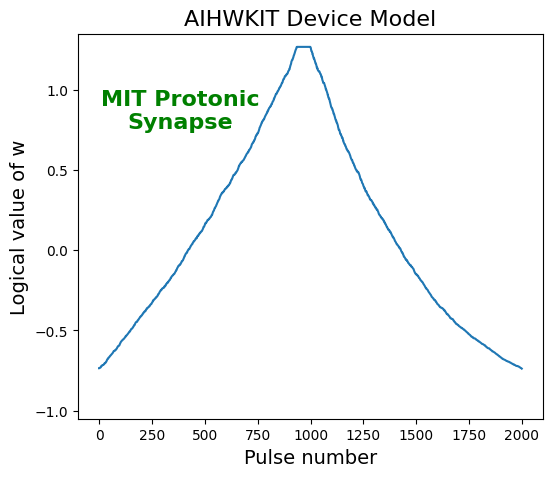

In [2]:
rpu_config = AGADEcRamPreset()
rpu_config.device.unit_cell_devices = [EcRamPresetDevice(
    construction_seed=6,
    gamma_up = -0.38,
    gamma_down = 0.76,
    allow_increasing=True
) for _ in range(2)]
rpu_config.device.fast_lr = 0.035
rpu_config.device.in_chop_prob = 0.0
rpu_config.device.construction_seed = 45

plt.figure(figsize=(6, 5),dpi=100)
model = Network(rpu_config=rpu_config)
optimizer = AnalogSGD(model.parameters(), lr=0.01)

params = model.l1.get_hidden_parameters()
params['fast_weight'] = params['min_bound_0']
params['slow_weight_1'] = torch.tensor([[0]])
model.l1.set_hidden_parameters(params)

w_C = []
w_A = []
W_Buff = []

for i in range(4000):
    if i < 1000 or i > 2000 and i < 3000:
        y = model(torch.tensor([[1.0]]))
        l = (1 - y)
    else:
        y = model(torch.tensor([[1.0]]))
        l = y

    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i >= 2000:
        params = model.l1.get_hidden_parameters()
        w_C.append([params['slow_weight_1'].item()])
        w_A.append(params['fast_weight'].item())
        W_Buff.append(params['hidden_weight'].item())

# # Mirror the first half of the data points
# midpoint = len(w_A) // 2
# first_half = w_A[:midpoint]
# second_half = w_A[midpoint:]

# # Calculate the line to mirror against
# start_val = w_A[0]
# peak_val = w_A[midpoint]
# mirror_line = np.linspace(start_val, peak_val, midpoint)

# # Mirror the first half
# mirrored_first_half = 2 * mirror_line - first_half

# # Combine the mirrored first half with the original second half
# w_A_mirrored = np.concatenate([mirrored_first_half, second_half])

plt.plot(w_A)
plt.title('AIHWKIT Device Model', fontsize=16)
plt.xlabel('Pulse number', fontsize=14)
plt.ylabel('Logical value of w', fontsize=14)
plt.ylim(-1.05, 1.35)

# place text in the middle of the plot
plt.text(0.22, 0.8, 'MIT Protonic\nSynapse', fontsize=16, ha='center', va='center', transform=plt.gca().transAxes, color='green', weight='bold')

## Training

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from IPython.display import clear_output

def test_evaluation(model, val_set, classifier):
    """Test trained network

    Args:
        model (nn.Model): Trained model to be evaluated
        val_set (DataLoader): Validation set to perform the evaluation
    """
    # Setup counter of images predicted to 0.
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in val_set:
        images = images.view(images.shape[0], -1)
        pred = model(images)

        loss = classifier(pred, labels)

        total_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()

    accuracy = predicted_ok / total_images
    loss = total_loss / total_images
    return loss, accuracy

def training_run(train_set, validation_set, model, swa_tracker, optimizer, scheduler, loss_fn, epochs):

    l = []
    a = []
    num_tiles = model.l1.rpu_config.batch_size
    
    for e in range(epochs):
        model.train()
        print(f"Epoch {e+1}/{epochs}")

        for x, y_true in train_set:
            # Flatten MNIST images into a 784 vector.
            x = x.view(x.shape[0], -1)
            
            
            output = model(x)
            # Compute loss
            loss = loss_fn(output, y_true)

            # regroup output and target to compute tile specific losses
            # Calculate inputs per tile as in the forward pass
            batch_size = x.shape[0]
            inputs_per_tile = (batch_size + num_tiles - 1) // num_tiles

            # Initialize list for tile losses
            tile_losses = []

            # Calculate loss for each tile using the same distribution logic
            # with torch.no_grad():
            #     for i in range(num_tiles):
            #         # Get the start and end indices for this tile
            #         start_idx = i * inputs_per_tile
            #         end_idx = min(start_idx + inputs_per_tile, batch_size)
                    
            #         # Skip if this tile didn't receive any inputs
            #         if start_idx >= batch_size:
            #             continue
                        
            #         # Get outputs and targets for this tile
            #         tile_output = output[start_idx:end_idx]
            #         tile_target = y_true[start_idx:end_idx]
                    
            #         # Calculate loss
            #         tile_loss = loss_fn(tile_output, tile_target)
            #         tile_losses.append(tile_loss.item())
                    
            #         # Update running loss average
            #         swa_tracker.update_tile_loss(i, tile_loss.item())

            # backward pass
            loss.backward()

            # update params
            optimizer.step()
            optimizer.zero_grad()

        # model.digitize_model()
        # loss, acc = test_evaluation(model, validation_set, loss_fn)
        # l.append(loss)
        # a.append(acc)

         # Update SWA tracker
        swa_tracker.update(e, collect_performance=False)

        # Decay learning rate if needed.
        # if acc > 0.90 and scheduler.get_last_lr()[0] >= 0.1 \
        #     or acc > 0.95 and scheduler.get_last_lr()[0] >= 0.05:
        #     print("Decaying learning rate from {} to {}".format(scheduler.get_last_lr()[0], scheduler.get_last_lr()[0] * 0.5))
        #     scheduler.step()

        # if (e+1) % 1 == 0:
        #     clear_output(wait=True)
        #     plt.plot(l)
        #     plt.title(f'Final Loss: {np.mean(l[-1:]):.2f}')
        #     plt.xlabel('Epoch')
        #     plt.ylabel('Loss')
        #     plt.show()
        #     if a != []:
        #         plt.plot(a)
        #         plt.title(f'Final Accuracy: {np.mean(a[-1:]):.2f}')
        #         plt.xlabel('Epoch')
        #         plt.ylabel('Accuracy')
        #         plt.show()
        
        # if np.isnan(l[-1]):
        #     break

    return l, a


### MNIST


In [4]:
from aihwkit.simulator.tiles.transfer_for_batched_TTv2 import TorchTransferTile
from aihwkit.optim import AnalogSGD
import torch.nn as nn
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.presets import AGADEcRamPreset
from torch.optim.lr_scheduler import StepLR
import time


# Network definition.
INPUT_SIZE = 784
HIDDEN_SIZES = [256, 128]
OUTPUT_SIZE = 10

class Analog_Network(nn.Module):

    def __init__(self, rpu_config, t = [1,1,1], max_iter=500, w_init=0.1, max_iter_zero=1000):
        super(Analog_Network, self).__init__()

        rpu_config.device.units_in_mbatch = True
        rpu_config.mapping.learn_out_scaling = True
        rpu_config.device.transfer_every = t[0]
        self.l1 = TorchTransferTile(
            INPUT_SIZE,
            HIDDEN_SIZES[0],
            rpu_config,
            True,
        )
        rpu_config.device.transfer_every = t[1]
        self.l2 = TorchTransferTile(
            HIDDEN_SIZES[0],
            HIDDEN_SIZES[1],
            rpu_config,
            True,
        )
        rpu_config.device.transfer_every = t[2]
        self.l3 = TorchTransferTile(
            HIDDEN_SIZES[1],
            OUTPUT_SIZE,
            rpu_config,
            True,
        )
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # initialize weights with xavier
        init_w = torch.nn.init.xavier_normal_(self.l1.get_weights()[0][0])
        self.l1.set_weights(init_w)
        self.l1.program_weights(False, max_iter=max_iter, w_init=w_init, max_iter_zero=max_iter_zero)

        init_w = torch.nn.init.xavier_normal_(self.l2.get_weights()[0][0])
        self.l2.set_weights(init_w)
        self.l2.program_weights(False, max_iter=max_iter, w_init=w_init, max_iter_zero=max_iter_zero)

        init_w = torch.nn.init.xavier_normal_(self.l3.get_weights()[0][0])
        self.l3.set_weights(init_w)
        self.l3.program_weights(False, max_iter=max_iter, w_init=w_init, max_iter_zero=max_iter_zero)
        

    def digitize_model(self):
        w_l1 = torch.mean(self.l1.read_weights(apply_weight_scaling=True)[0], dim=0)
        w_l2 = torch.mean(self.l2.read_weights(apply_weight_scaling=True)[0], dim=0) 
        w_l3 = torch.mean(self.l3.read_weights(apply_weight_scaling=True)[0], dim=0)
        self.l1_n = nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0], bias=True)
        self.l1_n.weight.data = w_l1
        self.l1_n.bias.data = self.l1.get_weights()[1]
        self.l2_n = nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], bias=True)
        self.l2_n.weight.data = w_l2
        self.l2_n.bias.data = self.l2.get_weights()[1]
        self.l3_n = nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE, bias=True)
        self.l3_n.weight.data = w_l3
        self.l3_n.bias.data = self.l3.get_weights()[1]

    def forward(self, x):
        if self.training:
            x = self.l1(x)
            x = torch.sigmoid(x)
            x = self.l2(x)
            x = torch.sigmoid(x)
            x = self.l3(x)
            x = self.logsoftmax(x)
            return x 
        else:
            with torch.no_grad():
                x = self.l1_n(x)
                x = torch.sigmoid(x)
                x = self.l2_n(x)
                x = torch.sigmoid(x)
                x = self.l3_n(x)
                x = self.logsoftmax(x)
                return x 

In [5]:
from aihwkit.simulator.tiles.transfer_for_batched_TTv2_v2_log import TorchTransferTile
from aihwkit.optim import AnalogSGD
import torch.nn as nn
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.presets import AGADEcRamPreset
from torch.optim.lr_scheduler import StepLR
import time


# Network definition.
INPUT_SIZE = 784
HIDDEN_SIZES = [256, 128]
OUTPUT_SIZE = 10

class Analog_Network(nn.Module):

    def __init__(self, rpu_config, t = [1,1,1], max_iter=500, w_init=0.4, max_iter_zero=3000):
        super(Analog_Network, self).__init__()

        rpu_config.device.units_in_mbatch = True
        rpu_config.mapping.learn_out_scaling = True
        rpu_config.device.transfer_every = t[0]
        self.l1 = TorchTransferTile(
            INPUT_SIZE,
            HIDDEN_SIZES[0],
            rpu_config,
            True,
        )
        rpu_config.device.transfer_every = t[1]
        self.l2 = TorchTransferTile(
            HIDDEN_SIZES[0],
            HIDDEN_SIZES[1],
            rpu_config,
            True,
        )
        rpu_config.device.transfer_every = t[2]
        self.l3 = TorchTransferTile(
            HIDDEN_SIZES[1],
            OUTPUT_SIZE,
            rpu_config,
            True,
        )
        self.logsoftmax = nn.LogSoftmax(dim=1)

        num_tiles = self.l1.rpu_config.batch_size
        # initialize weights with xavier
        init_w = torch.nn.init.xavier_normal_(self.l1.get_weights()[0][0])
        #init_w = torch.nn.init.kaiming_normal_(self.l1.get_weights()[0][0])
        self.init_w1 = init_w
        self.l1.tile.program_weights_from_one([init_w for _ in range(num_tiles)], max_iter=max_iter, w_init=w_init, 
                                               max_iter_zero=max_iter_zero)

        init_w = torch.nn.init.xavier_normal_(self.l2.get_weights()[0][0])
        #init_w = torch.nn.init.kaiming_normal_(self.l2.get_weights()[0][0])
        self.init_w2 = init_w
        self.l2.tile.program_weights_from_one([init_w for _ in range(num_tiles)], max_iter=max_iter, w_init=w_init,
                                                  max_iter_zero=max_iter_zero)

        init_w = torch.nn.init.xavier_normal_(self.l3.get_weights()[0][0])
        #init_w = torch.nn.init.kaiming_normal_(self.l3.get_weights()[0][0])
        self.init_w3 = init_w
        self.l3.tile.program_weights_from_one([init_w for _ in range(num_tiles)], max_iter=max_iter, w_init=w_init,
                                                    max_iter_zero=max_iter_zero)
        

    def digitize_model(self):
        w_l1 = torch.mean(self.l1.tile.read_weights(), dim=0) * self.l1.get_scales().item()
        w_l2 = torch.mean(self.l2.tile.read_weights(), dim=0) * self.l2.get_scales().item()
        w_l3 = torch.mean(self.l3.tile.read_weights(), dim=0) * self.l3.get_scales().item()
        self.l1_n = nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0], bias=True)
        self.l1_n.weight.data = w_l1
        self.l1_n.bias.data = self.l1.get_weights()[1]
        self.l2_n = nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], bias=True)
        self.l2_n.weight.data = w_l2
        self.l2_n.bias.data = self.l2.get_weights()[1]
        self.l3_n = nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE, bias=True)
        self.l3_n.weight.data = w_l3
        self.l3_n.bias.data = self.l3.get_weights()[1]

    def forward(self, x):
        if self.training:
            x = self.l1(x)
            x = torch.sigmoid(x)
            #x = nn.LeakyReLU()(x)
            x = self.l2(x)
            x = torch.sigmoid(x)
            #x = nn.LeakyReLU()(x)
            x = self.l3(x)
            x = self.logsoftmax(x)
            return x 
        else:
            with torch.no_grad():
                x = self.l1_n(x)
                x = torch.sigmoid(x)
                #x = nn.LeakyReLU()(x)
                x = self.l2_n(x)
                x = torch.sigmoid(x)
                #x = nn.LeakyReLU()(x)
                x = self.l3_n(x)
                x = self.logsoftmax(x)
                return x 

In [6]:
import copy
import math
import torch
import torch.nn as nn

class SWATracker:
    """Stochastic Weight Averaging tracker for aihwkit analog models."""
    
    def __init__(self, model, swa_start=40, swa_freq=1):
        """
        Args:
            model: The Analog_Network model
            swa_start: Epoch to start collecting weights for SWA
            swa_freq: Frequency (in epochs) to collect weights
            input_size: Input dimension size (required for creating averaged model)
            hidden_sizes: List of hidden layer sizes (required for creating averaged model)
            output_size: Output dimension size (required for creating averaged model)
        """
        self.model = model
        self.swa_start = swa_start
        self.swa_freq = swa_freq
        
        # Storage for standard SWA weights (unweighted averaging)
        self.swa_weights = {
            'l1': {'weight': None, 'bias': None, 'count': 0},
            'l2': {'weight': None, 'bias': None, 'count': 0},
            'l3': {'weight': None, 'bias': None, 'count': 0}
        }
        
        # Storage for performance-weighted SWA weights
        self.weighted_swa_weights = {
            'l1': {'weight': None, 'bias': None, 'count': 0},
            'l2': {'weight': None, 'bias': None, 'count': 0},
            'l3': {'weight': None, 'bias': None, 'count': 0}
        }
        
        # For performance-weighted averaging
        self.n_tiles = model.l1.rpu_config.batch_size  # Number of tiles in batch
        self.tile_losses = [0.0] * self.n_tiles  # Running losses for each tile
        self.loss_update_count = [0] * self.n_tiles  # To track how many updates each tile received
        
    def update(self, epoch, collect_performance=True, temperature=0.2):
        """Update SWA weights if conditions are met."""
        if epoch < self.swa_start:
            return
            
        if epoch % self.swa_freq != 0:
            return
        
        # If we're collecting performance metrics, also update the weighted average
        if collect_performance and sum(self.loss_update_count) > 0:
            # Get current weights from all tiles
            l1_weights, l1_bias = self.model.l1.tile.read_weights() * self.model.l1.get_scales().item(), self.model.l1.get_weights()[1]
            l2_weights, l2_bias = self.model.l2.tile.read_weights() * self.model.l2.get_scales().item(), self.model.l2.get_weights()[1]
            l3_weights, l3_bias = self.model.l3.tile.read_weights() * self.model.l3.get_scales().item(), self.model.l3.get_weights()[1]

            # Get current weights from all tiles
            # l1_weights, l1_bias = self.model.l1.read_weights(apply_weight_scaling=True)
            # l2_weights, l2_bias = self.model.l2.read_weights(apply_weight_scaling=True)
            # l3_weights, l3_bias = self.model.l3.read_weights(apply_weight_scaling=True)

            self._update_weighted_swa(l1_weights, l1_bias, l2_weights, l2_bias, l3_weights, l3_bias, temperature)
        else:
            # Get current weights from all tiles
            l1_weights, l1_bias = self.model.l1.tile.read_weights_multi() * self.model.l1.get_scales().item(), self.model.l1.get_weights()[1]
            l2_weights, l2_bias = self.model.l2.tile.read_weights_multi() * self.model.l2.get_scales().item(), self.model.l2.get_weights()[1]
            l3_weights, l3_bias = self.model.l3.tile.read_weights_multi() * self.model.l3.get_scales().item(), self.model.l3.get_weights()[1]

            # Get current weights from all tiles
            # l1_weights, l1_bias = self.model.l1.read_weights_multi(apply_weight_scaling=True)
            # l2_weights, l2_bias = self.model.l2.read_weights_multi(apply_weight_scaling=True)
            # l3_weights, l3_bias = self.model.l3.read_weights_multi(apply_weight_scaling=True)
        
        # Update standard SWA (unweighted average across tiles)
        self._update_unweighted_swa(l1_weights, l1_bias, l2_weights, l2_bias, l3_weights, l3_bias)
    
    def _update_unweighted_swa(self, l1_weights, l1_bias, l2_weights, l2_bias, l3_weights, l3_bias):
        """Update standard SWA running mean (average across tiles without performance weighting)"""
        for layer_name, layer_weights in [('l1', (l1_weights, l1_bias)), 
                                         ('l2', (l2_weights, l2_bias)), 
                                         ('l3', (l3_weights, l3_bias))]:
            weights, bias = layer_weights

            if len(weights.shape) == 3: 
                avg_weight = torch.mean(weights, dim=0)  # Simple average across tiles
            else:
                avg_weight = weights
            
            if self.swa_weights[layer_name]['weight'] is None:
                # First collection
                self.swa_weights[layer_name]['weight'] = avg_weight
                self.swa_weights[layer_name]['bias'] = bias
            else:
                # Update running average
                n = self.swa_weights[layer_name]['count']
                alpha = 1.0 / (n + 1)
                self.swa_weights[layer_name]['weight'] = (1.0 - alpha) * self.swa_weights[layer_name]['weight'] + alpha * avg_weight
                self.swa_weights[layer_name]['bias'] = (1.0 - alpha) * self.swa_weights[layer_name]['bias'] + alpha * bias
            
            self.swa_weights[layer_name]['count'] += 1
            
    def _update_weighted_swa(self, l1_weights, l1_bias, l2_weights, l2_bias, l3_weights, l3_bias, temperature=0.2):
        """Update performance-weighted SWA running mean"""
        # Get performance-based weights for each tile
        tile_weights = self.get_performance_weights(temperature)
        
        # Calculate weighted average across tiles for each layer
        l1_weighted_avg = torch.zeros_like(l1_weights[0])
        l2_weighted_avg = torch.zeros_like(l2_weights[0])
        l3_weighted_avg = torch.zeros_like(l3_weights[0])
        
        # Compute the weighted average across tiles
        for tile_idx, weight in enumerate(tile_weights):
            l1_weighted_avg += l1_weights[tile_idx] * weight
            l2_weighted_avg += l2_weights[tile_idx] * weight
            l3_weighted_avg += l3_weights[tile_idx] * weight
        
        # For biases (usually shared across tiles), just use the provided bias
        l1_bias_weighted = l1_bias
        l2_bias_weighted = l2_bias
        l3_bias_weighted = l3_bias
        
        # Update the running weighted averages
        for layer_name, layer_data in [('l1', (l1_weighted_avg, l1_bias_weighted)), 
                                      ('l2', (l2_weighted_avg, l2_bias_weighted)), 
                                      ('l3', (l3_weighted_avg, l3_bias_weighted))]:
            weighted_avg, bias = layer_data
            
            if self.weighted_swa_weights[layer_name]['weight'] is None:
                # First collection
                self.weighted_swa_weights[layer_name]['weight'] = weighted_avg
                self.weighted_swa_weights[layer_name]['bias'] = bias
            else:
                # Update running average
                n = self.weighted_swa_weights[layer_name]['count']
                alpha = 1.0 / (n + 1)
                self.weighted_swa_weights[layer_name]['weight'] = (1.0 - alpha) * self.weighted_swa_weights[layer_name]['weight'] + alpha * weighted_avg
                self.weighted_swa_weights[layer_name]['bias'] = (1.0 - alpha) * self.weighted_swa_weights[layer_name]['bias'] + alpha * bias
            
            self.weighted_swa_weights[layer_name]['count'] += 1
    
    def update_tile_loss(self, tile_idx, loss_value, momentum=0.9):
        """Update running loss for a specific tile."""
        if self.tile_losses[tile_idx] == 0.0 and self.loss_update_count[tile_idx] == 0:
            # First update
            self.tile_losses[tile_idx] = loss_value
        else:
            # Running average with momentum
            self.tile_losses[tile_idx] = momentum * self.tile_losses[tile_idx] + (1 - momentum) * loss_value
        
        self.loss_update_count[tile_idx] += 1
    
    def get_performance_weights(self, temperature=0.2):
        """
        Calculate weights based on tile performance (inverse loss).
        Higher temperature makes weights more uniform.
        """
        # Convert losses to inverse (better performance = higher weight)
        inv_losses = [1.0 / (loss + 1e-8) for loss in self.tile_losses]
        
        # Apply temperature scaling and softmax for more balanced weighting
        if temperature > 0:
            # Scale by temperature
            scaled_inv_losses = [inv_loss / temperature for inv_loss in inv_losses]
            
            # Softmax calculation
            max_val = max(scaled_inv_losses)
            exp_vals = [math.exp(val - max_val) for val in scaled_inv_losses]
            sum_exp = sum(exp_vals)
            weights = [exp_val / sum_exp for exp_val in exp_vals]
        else:
            # Just normalize
            sum_inv = sum(inv_losses)
            weights = [inv_loss / sum_inv for inv_loss in inv_losses]
            
        return weights
    
    def get_averaged_model(self, weighted=False):
        """Create a new model with SWA weights."""
        # Create new model with same config
        new_model = copy.deepcopy(self.model)
        new_model.eval()  # Put in eval mode
        
        # Choose which set of weights to use
        source_weights = self.weighted_swa_weights if weighted else self.swa_weights
        
        # Set up the layers with averaged weights
        new_model.l1_n = nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0], bias=True)
        new_model.l1_n.weight.data = source_weights['l1']['weight']
        new_model.l1_n.bias.data = source_weights['l1']['bias']
        
        new_model.l2_n = nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], bias=True)
        new_model.l2_n.weight.data = source_weights['l2']['weight']
        new_model.l2_n.bias.data = source_weights['l2']['bias']
        
        new_model.l3_n = nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE, bias=True)
        new_model.l3_n.weight.data = source_weights['l3']['weight']
        new_model.l3_n.bias.data = source_weights['l3']['bias']
        
        return new_model

In [7]:
from torchvision import datasets, transforms

# Path where the datasets will be stored.
PATH_DATASET = os.path.join("SHD_script/data", "DATASET")

def load_images(batch_size):
    """Load images for train from the torchvision datasets."""
    transform = transforms.Compose([transforms.ToTensor()])

    # Load the images.
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    return train_data, validation_data

#### Run

In [8]:
def calculate_pairwise_std(weights):
    """
    Calculate the standard deviation of all pairwise differences between tiles.
    
    Args:
        weights: Tensor of shape [num_tiles, ...] containing the weights for each tile
    
    Returns:
        Standard deviation of all pairwise differences
    """
    num_tiles = weights.shape[0]
    all_diffs = []
    
    # Compute all pairwise differences
    for i in range(num_tiles):
        for j in range(i+1, num_tiles):  # Only compute each pair once
            diff = weights[i] - weights[j]
            all_diffs.append(diff.flatten())
    
    # Stack all differences and compute std
    if all_diffs:
        all_diffs_tensor = torch.cat(all_diffs)
        return torch.std(all_diffs_tensor)
    else:
        return torch.tensor(0.0)  # Return 0 if there's only one tile

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 64

train, eval = load_images(batch_size)

lr = 0.1

rpu = AGADEcRamPreset()
rpu.device.fast_lr = lr
rpu.batch_size = 2
t = [1, 1, 1]
rpu.forward.out_noise = 0.1
# rpu.forward.out_bound = 0
# rpu.forward.is_perfect = True
# rpu.device.transfer_update.desired_bl = 32

model = Analog_Network(rpu_config=rpu, t=t, max_iter=10000, w_init=0.4, max_iter_zero=20000).to(device)
print("Intented:", torch.std(model.init_w1))
actual_weights = model.l1.get_weights()[0]
print("Actual:", torch.std(actual_weights))
l1 = model.l1.get_weights()[0]
print("Layer 1 pairwise difference std:", calculate_pairwise_std(actual_weights))

print("Intented:", torch.std(model.init_w2))
actual_weights = model.l2.get_weights()[0]
print("Actual:", torch.std(actual_weights))
l2 = model.l2.get_weights()[0]
print("Layer 2 pairwise difference std:", calculate_pairwise_std(actual_weights))

print("Intented:", torch.std(model.init_w3))
actual_weights = model.l3.get_weights()[0]
print("Actual:", torch.std(actual_weights))
l3 = model.l3.get_weights()[0]
print("Layer 3 pairwise difference std:", calculate_pairwise_std(actual_weights))

Iterations for tile 0: 8135
Average iterations: 10000.0
Iterations for tile 0: 2991
Average iterations: 6141.0
Iterations for tile 0: 1500
Average iterations: 5060.0
Intented: tensor(0.0439)
Actual: tensor(0.0438)
Layer 1 pairwise difference std: tensor(0.0356)
Intented: tensor(0.0718)
Actual: tensor(0.0675)
Layer 2 pairwise difference std: tensor(0.0244)
Intented: tensor(0.1195)
Actual: tensor(0.1161)
Layer 3 pairwise difference std: tensor(0.0256)


In [8]:
from aihwkit.simulator.tiles.analog_mvm import AnalogMVM

image = train.dataset.data[0].view(1, -1)
image = image.float() / 255.0
print(image[0][180:190])

output = model.l1.tile.weight_tiles[0].tile.forward(image)
print(output[0][0:10])

output = model.l1(image)
print(output[0][0:10] / 5.0)

tensor([0.6667, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.8824, 0.6745, 0.9922,
        0.9490])
tensor([ 1.0980,  0.7843,  1.8039,  4.9412,  2.4314,  0.9412, -3.7647, -0.0784,
         3.2157,  3.6078])
tensor([ 0.1725,  0.1255,  0.3451,  1.0196,  0.4549,  0.2039, -0.7373, -0.0314,
         0.6588,  0.7529], grad_fn=<DivBackward0>)


In [ ]:
import pandas as pd
df1 = pd.DataFrame(model.l1.tile.log)
df2 = pd.DataFrame(model.l2.tile.log)
df3 = pd.DataFrame(model.l3.tile.log)

# add a layer column and concatenate

df = pd.concat([df1, df2, df3], axis=0)
df['layer'] = ['l1'] * len(df1) + ['l2'] * len(df2) + ['l3'] * len(df3)

#df.to_csv('SHD_script/program_optim_mc3.csv', index=False)
df

In [ ]:
import pandas as pd
df1 = pd.DataFrame(model.l1.tile.log)
df2 = pd.DataFrame(model.l2.tile.log)
df3 = pd.DataFrame(model.l3.tile.log)

# add a layer column and concatenate

df = pd.concat([df1, df2, df3], axis=0)
df['layer'] = ['l1'] * len(df1) + ['l2'] * len(df2) + ['l3'] * len(df3)

#df.to_csv('SHD_script/program_optim_mc3.csv', index=False)
df

,Type,Tile,Op,Meta_op,Times,Pfactor,layer
0,analog,main,forward,program,8092,1.000000,l1
1,analog,main,update,program,8092,1.000000,l1
2,analog,main,forward,program,243838,14.725397,l1
3,analog,main,update,program,228332,14.725397,l1
0,analog,main,forward,program,2985,1.000000,l2
1,analog,main,update,program,2985,1.000000,l2
2,analog,main,forward,program,96669,14.698116,l2
3,analog,main,update,program,90511,14.698116,l2
0,analog,main,forward,program,1510,1.000000,l3
1,analog,main,update,program,1510,1.000000,l3


### To experiment with std and variance

In [ ]:
outputs = []
maxs = []
model.l1.set_weights(torch.randn_like(model.l1.get_weights()[0][0])*0.2)
for i in range(10000):
    input = torch.randn(1, 784)
    input = input / 28
    maxs.append(torch.max(input.abs()))
    output = model.l1(input)
    outputs.append(output)
# Stack outputs and calculate the standard deviation
outputs = torch.stack(outputs)  # Shape: [10000, output_dim]
mean_output = torch.mean(outputs, dim=0)  # Mean across runs
noise = outputs #- mean_output  # Noise is the deviation from the mean
std = torch.var(noise, dim=0)  # Standard deviation of the noise
maxs = torch.stack(maxs)
# Report the mean standard deviation as the forward noise
print("Forward noise (mean std):", torch.mean(std).item())
print("Mean Max input:", torch.mean(maxs))

NameError: name 'model' is not defined

GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
SET WEIGHTS
WEIGHT SCALING
Forward var: 0.010154291987419128
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
SET WEIGHTS
WEIGHT SCALING
Forward var: 0.049920715391635895
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
SET WEIGHTS
WEIGHT SCALING
Forward var: 0.09915020316839218
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
SET WEIGHTS
WEIGHT SCALING
Forward var: 0.14519105851650238
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GET MAPPING SCALES
SET WEIGHTS
WEIGHT SCALING
Forward var: 0.18749995529651642
GET WEIGHTS
GET SCALES
GET LEARNED OUT SCALES
GE

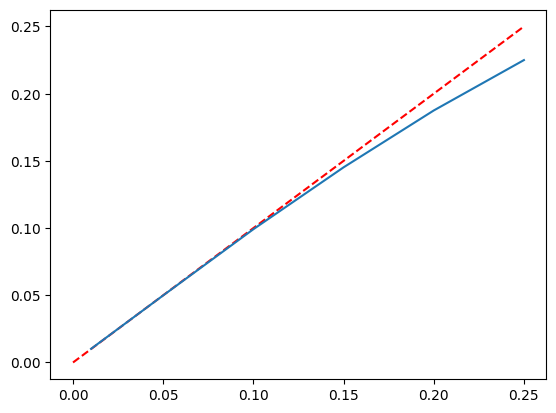

In [ ]:
# testing how the variance of the output can predict the variance of the weights

vars = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
results = []
for s in vars:
    outputs = []
    l1 = torch.randn_like(model.l1.get_weights()[0][0])*math.sqrt(s)
    model.l1.set_weights(torch.randn_like(model.l1.get_weights()[0][0])*math.sqrt(s))
    for i in range(10000):
        input = torch.randn(1, 784)
        input = input / 28
        output = model.l1(input)
        #output = l1 @ input.T
        outputs.append(output)
    outputs = torch.stack(outputs) 
    var = torch.var(outputs, dim=0)
    print("Forward var:", torch.mean(var).item())

    results.append(torch.mean(var).item())

# plot a reference curve at y=x**2
plt.plot([0, 0.25], [0, 0.25], 'r--', label='y=x^2')
plt.plot(vars, results)

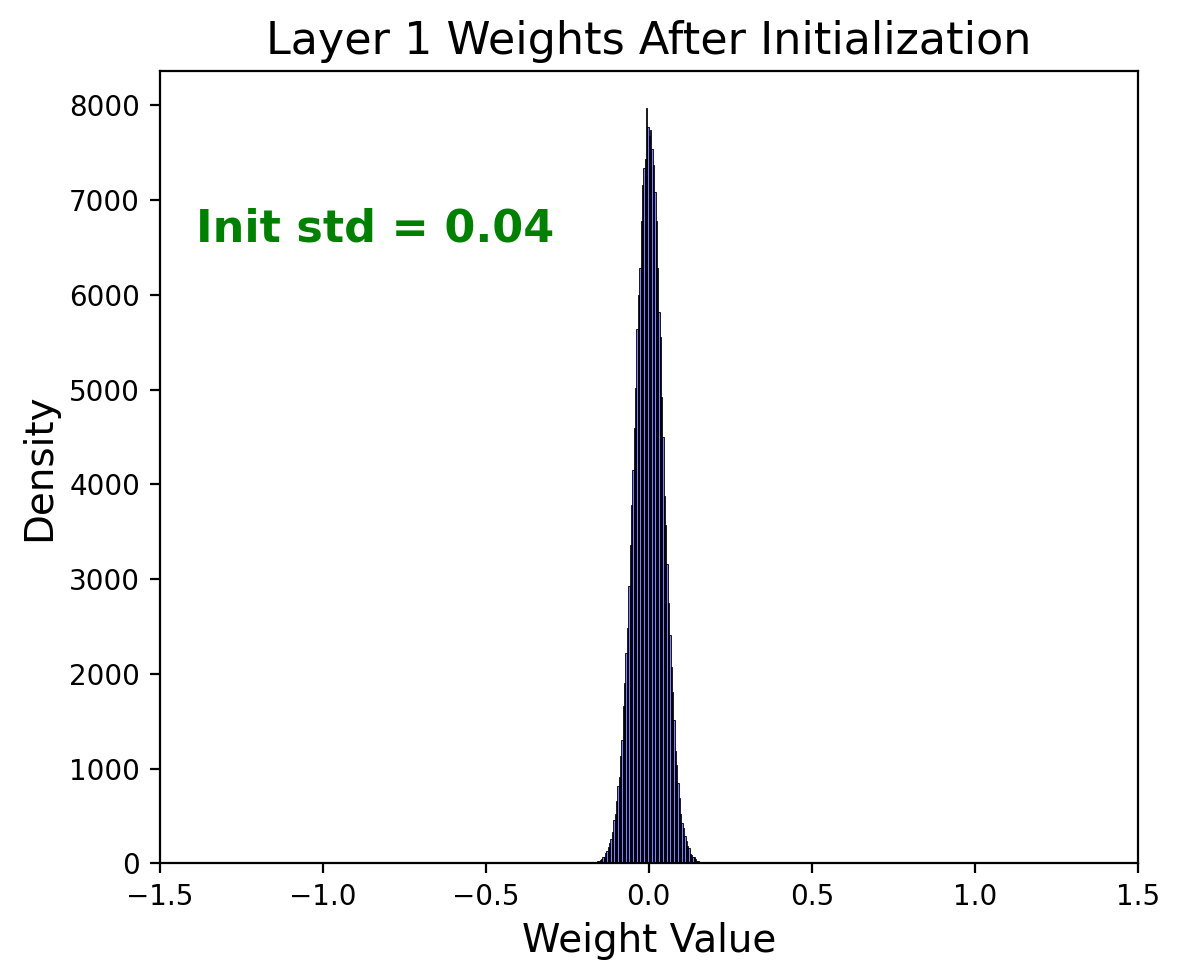

In [17]:
# plot a normal distribution with std 1 and cliped to -1, 1
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' is your PyTorch model
first_layer_weights = model.l1.get_weights()[0][0].numpy().flatten()
#first_layer_weights = model.init_w1.flatten().numpy()
#std = str(torch.std(model.init_w1).item())[0:4]

# Create the distribution plot
plt.figure(figsize=(6, 5), dpi=200)

sns.histplot(first_layer_weights, kde=True, bins=100, color='blue', line_kws={'linewidth': 0}, label='FP', alpha=0.5)

plt.title('Layer 1 Weights After Initialization', fontsize=16)
plt.xlabel('Weight Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(-1.5, 1.5)
plt.tight_layout()
plt.text(0.22, 0.8, 'Init std = 0.04', fontsize=16, ha='center', va='center', transform=plt.gca().transAxes, color='green', weight='bold')
plt.show()

### Test different methods to get graphs of required pulses

In [ ]:
bls = [1, 10]
max_iters = [0,10,100,250,500,750,1000]#
results = []

#rpu.forward.is_perfect = True
for bl in bls:
    for max_iter in max_iters:
        rpu.device.transfer_update.desired_bl = bl
        model = Analog_Network(rpu_config=rpu, t=t, max_iter=max_iter, w_init=0.4).to(device)
        intended_weights = model.init_w1
        actual_weights = model.l1.get_weights()[0]
        std = []
        for i in range(actual_weights.shape[0]):
            std.append(torch.std(intended_weights - actual_weights))
        std = torch.stack(std)
        print("BL:", bl, "  Max iter:", max_iter, "  Mean:", std.mean())
        results.append({
            'bl': bl,
            'iters': max_iter,
            'std': std.mean().item(),
        })

In [ ]:
bls = [1]
max_iters = [0,10,50,100,250,500]#
max_iters_zero = [0,100,250,500,1000,2500,5000,10000]#
results = []

#rpu.forward.is_perfect = True
for bl in bls:
    for max_iter in max_iters:
        for max_iter_zero in max_iters_zero:
            rpu.device.transfer_update.desired_bl = bl
            model = Analog_Network(rpu_config=rpu, t=t, max_iter_zero=max_iter_zero, w_init=0.4, max_iter=max_iter).to(device)
            intended_weights = model.init_w3
            actual_weights = model.l3.get_weights()[0]
            std = []
            for i in range(actual_weights.shape[0]):
                std.append(torch.std(intended_weights - actual_weights))
            std = torch.stack(std)
            print("  Max iter:", max_iter, "    Max_iter_zero:", max_iter_zero, "  Mean:", std.mean())
            results.append({
                'bl': bl,
                'iters': max_iter,
                'iters_zero': max_iter_zero,
                'std': std.mean().item(),
            })

In [ ]:
import pandas as pd
bls = [31]
w_inits = [0.1, 0.2, 0.3, 0.4]
max_iters_zero = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]#
results = []

#rpu.forward.is_perfect = True
for bl in bls:
    for w_init in w_inits:
        for max_iter_zero in max_iters_zero:
            rpu.device.transfer_update.desired_bl = bl
            model = Analog_Network(rpu_config=rpu, t=t, max_iter_zero=max_iter_zero, w_init=w_init, max_iter=1000).to(device)
            intended_weights = model.init_w3
            actual_weights = model.l3.get_weights()[0]
            std = []
            for i in range(actual_weights.shape[0]):
                std.append(torch.std(intended_weights - actual_weights))
            std = torch.stack(std)
            log = model.l3.tile.log 
            df = pd.DataFrame(log)
            # select from df the columns in where meta-op is program and op is update
            df = df[(df['Meta_op'] == 'program') & (df['Op'] == 'update')]
            total_updates = df['Times'] / rpu.batch_size
            print("  Max_iter_zero:", max_iter_zero, "  Mean:", std.mean(), "  Iters:", total_updates.mean())
            results.append({
                'bl': bl,
                'w_init': w_init,
                'iters': total_updates.mean().item(),
                'iters_zero': max_iter_zero,
                'std': std.mean().item(),
            })

In [ ]:
import pandas as pd
bls = [1]
t_stds = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]
max_iters_zero = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]#
results = []

#rpu.forward.is_perfect = True
for bl in bls:
    for t_std in t_stds:
        for max_iter_zero in max_iters_zero:
            rpu.device.transfer_update.desired_bl = bl
            model = Analog_Network(rpu_config=rpu, t=t, max_iter_zero=max_iter_zero, w_init=0.4, max_iter=1000, t_std=t_std).to(device)
            intended_weights = model.init_w3
            actual_weights = model.l3.get_weights()[0]
            std = []
            for i in range(actual_weights.shape[0]):
                std.append(torch.std(intended_weights - actual_weights))
            std = torch.stack(std)
            log = model.l3.tile.log 
            df = pd.DataFrame(log)
            # select from df the columns in where meta-op is program and op is update
            df = df[(df['Meta_op'] == 'program') & (df['Op'] == 'update')]
            total_updates = df['Times'] / rpu.batch_size
            print("  Max_iter_zero:", max_iter_zero, "  Mean:", std.mean(), "  Iters:", total_updates.mean())
            results.append({
                'bl': bl,
                't_std': t_std,
                'iters': total_updates.mean().item(),
                'iters_zero': max_iter_zero,
                'std': std.mean().item(),
            })

In [ ]:
import pandas as pd
df = pd.DataFrame(results)
df.to_csv('SHD_script/program_optim_tstd.csv', index=False)

### Run and gather logs

In [11]:
rpu = AGADEcRamPreset()
rpu.device.unit_cell_devices = [EcRamPresetDevice(
    gamma_up = -0.38,
    gamma_down = 0.76,
    allow_increasing=True
) for _ in range(2)]
rpu.device.fast_lr = 0.01
#rpu.device.in_chop_prob = 0.001
rpu.batch_size = 4

print(rpu.update.desired_bl)

31


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 64

train, eval = load_images(batch_size)

lr = 0.1 #* 31 #* batch_size

rpu = AGADEcRamPreset()
rpu.device.unit_cell_devices = [EcRamPresetDevice(
    gamma_up = -0.38,
    gamma_down = 0.76,
    allow_increasing=True
) for _ in range(2)]
rpu.device.fast_lr = lr 
#rpu.device.in_chop_prob = 0.001
rpu.batch_size = 4
t = [1, 1, 1]

# rpu.forward.out_noise = 0.0
# rpu.device.transfer_forward.out_noise = 0.0
# rpu.forward.is_perfect = True
# rpu.update.desired_bl = 31

model = Analog_Network(rpu_config=rpu, t=t, max_iter=20000, w_init=0.4, max_iter_zero=10000).to(device)
swa_tracker = SWATracker(model, swa_start=35, swa_freq=1)
optimizer = AnalogSGD(model.parameters(), lr=lr)
optimizer.regroup_param_groups(model)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

loss_fn = nn.NLLLoss()

loss, accuracy = training_run(train, eval, model, swa_tracker, optimizer, scheduler, loss_fn, 40)

swa_model = swa_tracker.get_averaged_model(weighted=False)

#weighted_swa_model = swa_tracker.get_averaged_model(weighted=True)


In [11]:
import pandas as pd
df1 = pd.DataFrame(model.l1.tile.dlog)
df2 = pd.DataFrame(model.l1.plog)
df = pd.concat([df1, df2], axis=0)
df.to_csv('SHD_script/dlog_16_new.csv', index=False)

df = pd.DataFrame(model.l1.tile.log)
df.to_csv('SHD_script/log_16_new.csv', index=False)

In [11]:
model.digitize_model()
loss, acc = test_evaluation(model, eval, loss_fn)
print(f"Basic Final loss: {loss:.4f}, Final accuracy: {acc:.4f}")

loss, acc = test_evaluation(swa_model, eval, loss_fn)
print(f"SWA Final loss: {loss:.4f}, Final accuracy: {acc:.4f}")

# loss, acc = test_evaluation(weighted_swa_model, eval, loss_fn)
# print(f"Weighted SWA Final loss: {loss:.4f}, Final accuracy: {acc:.4f}")

Basic Final loss: 0.0923, Final accuracy: 0.9734
SWA Final loss: 0.0876, Final accuracy: 0.9741


In [ ]:
model.digitize_model()
loss, acc = test_evaluation(model, eval, loss_fn)
print(f"Basic Final loss: {loss:.4f}, Final accuracy: {acc:.4f}")

loss, acc = test_evaluation(swa_model, eval, loss_fn)
print(f"SWA Final loss: {loss:.4f}, Final accuracy: {acc:.4f}")

loss, acc = test_evaluation(weighted_swa_model, eval, loss_fn)
print(f"Weighted SWA Final loss: {loss:.4f}, Final accuracy: {acc:.4f}")

Basic Final loss: 0.1188, Final accuracy: 0.9734
SWA Final loss: 0.0894, Final accuracy: 0.9771
Weighted SWA Final loss: 0.0892, Final accuracy: 0.9774


### Run and collect all configurations

In [ ]:
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 64

train, eval = load_images(batch_size)

lr = 0.1 #* 31 #* batch_size
num_tiles = [1, 4, 8, 16, 32]
num_epochs = [40, 40, 40, 40, 40]

for nt, ne in zip(num_tiles, num_epochs):

    rpu = AGADEcRamPreset()
    rpu.device.unit_cell_devices = [EcRamPresetDevice(
        gamma_up = -0.38,
        gamma_down = 0.76,
        allow_increasing=True
    ) for _ in range(2)]
    rpu.device.fast_lr = lr 
    #rpu.device.in_chop_prob = 0.001
    rpu.batch_size = nt
    t = [1, 1, 1]

    model = Analog_Network(rpu_config=rpu, t=t, max_iter=20000, w_init=0.4, max_iter_zero=10000).to(device)
    swa_tracker = SWATracker(model, swa_start=35, swa_freq=1)
    optimizer = AnalogSGD(model.parameters(), lr=lr)
    optimizer.regroup_param_groups(model)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

    loss_fn = nn.NLLLoss()

    loss, accuracy = training_run(train, eval, model, swa_tracker, optimizer, scheduler, loss_fn, ne)

    swa_model = swa_tracker.get_averaged_model(weighted=False)

    model.digitize_model()
    loss, acc = test_evaluation(model, eval, loss_fn)
    print(f"Basic Final loss: {loss:.4f}, Final accuracy: {acc:.4f} for {nt} tiles")

    loss, acc = test_evaluation(swa_model, eval, loss_fn)
    print(f"SWA Final loss: {loss:.4f}, Final accuracy: {acc:.4f} for {nt} tiles")

    dfla_1 = pd.DataFrame(model.l1.tile.dlog)
    dfpe_1 = pd.DataFrame(model.l1.plog)
    ddf_1 = pd.concat([dfla_1, dfpe_1], axis=0)
    adf_1 = pd.DataFrame(model.l1.tile.log)

    dfla_2 = pd.DataFrame(model.l2.tile.dlog)
    dfpe_2 = pd.DataFrame(model.l2.plog)
    ddf_2 = pd.concat([dfla_2, dfpe_2], axis=0)
    adf_2 = pd.DataFrame(model.l2.tile.log)

    dfla_3 = pd.DataFrame(model.l3.tile.dlog)
    dfpe_3 = pd.DataFrame(model.l3.plog)
    ddf_3 = pd.concat([dfla_3, dfpe_3], axis=0)
    adf_3 = pd.DataFrame(model.l3.tile.log)

    ddf = pd.concat([ddf_1, ddf_2, ddf_3], axis=0)
    ddf['layer'] = ['l1'] * len(ddf_1) + ['l2'] * len(ddf_2) + ['l3'] * len(ddf_3)

    adf = pd.concat([adf_1, adf_2, adf_3], axis=0)
    adf['layer'] = ['l1'] * len(adf_1) + ['l2'] * len(adf_2) + ['l3'] * len(adf_3)

    ddf.to_csv(f'SHD_script/logs/dlog_{nt}_v1.csv', index=False) 
    adf.to_csv(f'SHD_script/logs/log_{nt}_v1.csv', index=False)

Iterations for tile 0: 8101
Average iterations: 0
Iterations for tile 0: 2982
Average iterations: 0
Iterations for tile 0: 1607
Average iterations: 0
Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40
Basic Final loss: 0.1007, Final accuracy: 0.9724 for 1 tiles
SWA Final loss: 87.7809, Final accuracy: 0.0972 for 1 tiles
Iterations for tile 0: 8132
Average iterations: 15122.333333333334
Iterations for tile 0: 3000
Average iterations: 5956.0
Iterations for tile 0: 1570
Average iterations: 4898.0
Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoc

In [ ]:
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 64

train, eval = load_images(batch_size)

lr = 0.1 #* 31 #* batch_size
num_tiles = [1, 4, 8, 16, 32]
num_epochs = [40, 45, 52, 58, 72]

for nt, ne in zip(num_tiles, num_epochs):

    rpu = AGADEcRamPreset()
    rpu.device.unit_cell_devices = [EcRamPresetDevice(
        gamma_up = -0.38,
        gamma_down = 0.76,
        allow_increasing=True
    ) for _ in range(2)]
    rpu.device.fast_lr = lr 
    #rpu.device.in_chop_prob = 0.001
    rpu.batch_size = nt
    t = [1, 1, 1]

    model = Analog_Network(rpu_config=rpu, t=t, max_iter=20000, w_init=0.4, max_iter_zero=10000).to(device)
    swa_tracker = SWATracker(model, swa_start=ne-5, swa_freq=1)
    optimizer = AnalogSGD(model.parameters(), lr=lr)
    optimizer.regroup_param_groups(model)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

    loss_fn = nn.NLLLoss()

    loss, accuracy = training_run(train, eval, model, swa_tracker, optimizer, scheduler, loss_fn, ne)

    swa_model = swa_tracker.get_averaged_model(weighted=False)

    model.digitize_model()
    loss, acc = test_evaluation(model, eval, loss_fn)
    print(f"Basic Final loss: {loss:.4f}, Final accuracy: {acc:.4f} for {nt} tiles")

    loss, acc = test_evaluation(swa_model, eval, loss_fn)
    print(f"SWA Final loss: {loss:.4f}, Final accuracy: {acc:.4f} for {nt} tiles")

    dfla_1 = pd.DataFrame(model.l1.tile.dlog)
    dfpe_1 = pd.DataFrame(model.l1.plog)
    ddf_1 = pd.concat([dfla_1, dfpe_1], axis=0)
    adf_1 = pd.DataFrame(model.l1.tile.log)

    dfla_2 = pd.DataFrame(model.l2.tile.dlog)
    dfpe_2 = pd.DataFrame(model.l2.plog)
    ddf_2 = pd.concat([dfla_2, dfpe_2], axis=0)
    adf_2 = pd.DataFrame(model.l2.tile.log)

    dfla_3 = pd.DataFrame(model.l3.tile.dlog)
    dfpe_3 = pd.DataFrame(model.l3.plog)
    ddf_3 = pd.concat([dfla_3, dfpe_3], axis=0)
    adf_3 = pd.DataFrame(model.l3.tile.log)

    ddf = pd.concat([ddf_1, ddf_2, ddf_3], axis=0)
    ddf['layer'] = ['l1'] * len(ddf_1) + ['l2'] * len(ddf_2) + ['l3'] * len(ddf_3)

    adf = pd.concat([adf_1, adf_2, adf_3], axis=0)
    adf['layer'] = ['l1'] * len(adf_1) + ['l2'] * len(adf_2) + ['l3'] * len(adf_3)

    ddf.to_csv(f'SHD_script/logs/dlog_{nt}_v2.csv', index=False) 
    adf.to_csv(f'SHD_script/logs/log_{nt}_v2.csv', index=False)

Iterations for tile 0: 8064
Average iterations: 0
Iterations for tile 0: 2963
Average iterations: 0
Iterations for tile 0: 1467
Average iterations: 0
Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40
Basic Final loss: 0.0937, Final accuracy: 0.9744 for 1 tiles
SWA Final loss: 19.0813, Final accuracy: 0.1361 for 1 tiles
Iterations for tile 0: 8128
Average iterations: 15172.0
Iterations for tile 0: 2990
Average iterations: 5941.333333333333
Iterations for tile 0: 1562
Average iterations: 5314.666666666667
Epoch 1/45
Epoch 2/45
Epoch 3/45
Epoch 4/45
Epoch 5/45
Epoch 6/45
Epoc

### Energy Table

In [ ]:
## values calculated using Cimloop 

e = {
    'buffer_784_read_8': 40.78,
    'buffer_784_write_8': 33.21,
    'buffer_256_read_8': 18.98,
    'buffer_256_write_8': 19.57,
    'buffer_128_read_8': 11.81,
    'buffer_128_write_8': 13.47,
    'buffer_10_read_8': 3.02,
    'buffer_10_write_8': 4.13,

    'buffer_784_read_32': 86.93,
    'buffer_784_write_32': 65.67,
    'buffer_256_read_32': 45.88,
    'buffer_256_write_32': 36.14,
    'buffer_128_read_32': 25.32,
    'buffer_128_write_32': 26.19,
    'buffer_10_read_32': 5.01,
    'buffer_10_write_32': 9.26,

    'adder_8': 0.164,
    'multiplier_8': 1.24,

    'adder_32': 0.33,
    'multiplier_32': 19.90,

    'forward_l1': 2554.36,
    'forward_l2': 1185.88,
    'forward_l3': 94.93,

    'backward_l1': 14026.40,
    'backward_l2': 2318.04,
    'backward_l3': 1137.41,

    # (DAC_rows + DAC_cols + Cells) * bl
    # cells = static + programming
    # static = V² * 5ns / 4.28Mo = 15.3fj per device per pulse (assuming 50-50 low high resistance)
    # programming = 0.25 * 0.005pj * num_devices
    'update_l1': (31*(599.70 + 359.46 + 182439.93*0.25)),#,3321.65
    'update_l2': (31*(158.95 + 101.74 + 29786.11*0.25)),#,542.31
    'update_l3': (31*(63.24 + 8.60 + 1175.04*0.25)),#,21.18

    # the pulse to C and the row read from A
    'transfer_l1': (1.43 + 359.46 + 232.70) + 2554.36*0.85,#4.39
    'transfer_l2': (1.43 + 101.74 + 116.35)+ 1185.88*0.85,#,2.11
    'transfer_l3': (1.43 + 8.60 + 9.18) + 94.93*0.85#,0.16
}

# store as json
import json
with open('SHD_script/logs/energy.json', 'w') as f:
    json.dump(e, f, indent=4)